## Creating a classifier that can distinguish between 3s and 7s

Skills covered in these notes:
- PIL and working with tensors

## Jargon Recap

- Activations: numbers calculated by linear and nonlinear layers
- Parameters: weights that are randomly initialised and then optimised by the model

These are all stored in tensors, which are matrices with axes / dimensions. 
- Rank 0 tensor: scalar
- Rank 1 tensor: vector
- Rank 2 tensor: matrix

Generally, neural networks alternate between linear layer and non-linear layer. (activation function)


- ReLU : Function that returns 0 for negative numbers and doesn't change positive numbers.
- Mini-batch : A small group of inputs and labels gathered together in two arrays. A gradient descent step is updated on this batch (rather than a whole epoch).
- Forward pass : Applying the model to some input and computing the predictions.
- Loss : A value that represents how well (or badly) our model is doing.
- Gradient : The derivative of the loss with respect to some parameter of the model.
- Backward pass : Computing the gradients of the loss with respect to all model parameters.
- Gradient descent : Taking a step in the directions opposite to the gradients to make the model parameters a little bit better.
- Learning rate : The size of the step we take when applying SGD to update the parameters of the model.

## Creating Tensors from MNIST Data

In [1]:
import fastbook
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
Path.BASE_PATH = path

Ideas for recognising 3s and 7s
1. Recognising linear and curved strokes and how they mesh together

Identifying a basline - comparing to the average 3 and the average 7
- find a simple, easy to implement model to see if your approach is any good

In [4]:
path.ls()

(#3) [Path('valid'),Path('train'),Path('labels.csv')]

In [5]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [6]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [7]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [8]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [9]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [10]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0



A tensor's length is its rank:
len(stacked_threes.shape) = 3 = tensor.ndim
shape = size of each axis of a tensor

Calculate the mean of all images by taking the mean along dimension 0 of a stacked, rank 3 tensor.
- Stacking over all the images 

## Computing Similarity

Idea is that we find the average pixel value for each of the 3s and the 7s, and then classify which of the two averages the image is closest to.

In [11]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
#Using python list comprehension
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

In [12]:
three_tensors[1].shape
#We have 6131 entries of a 28x28 in an array

torch.Size([28, 28])

In [13]:
stacked_sevens = torch.stack(seven_tensors).float()/255
#To typecast in PyTorch, type name of type as method
stacked_sevens.shape

torch.Size([6265, 28, 28])

<Axes: >

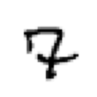

In [14]:
show_image(seven_tensors[2])

In [15]:
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

This has a rank of 3, consisting of 6131 , 28x28 pixels 

*Rank* is the number of axes or dimensions in the tensor. *shape* is the size of each axis in a tensor. Rank can be found by doing ```len(tensor.shape)``` or ```tensor.ndim```

2

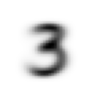

In [16]:
mean3 = stacked_threes.mean(0)
show_image(mean3)
mean3.ndim

<Axes: >

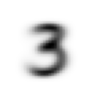

In [17]:
mean3 = stacked_threes.mean(0)
# this computes the mean along the 0th dimension of the tensor
show_image(mean3)

<Axes: >

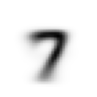

In [18]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

How to measure how a particlular image is different 
- compute the MSE values of every pixel?


**Mean absolute difference or L1 norm**
is the mean of the absolute value of differences
(a-b).abs().mean()
**MSE**
- mean of the squared error, 
- will punish larger differences more


**.backward**
- the same as calculate_grad

## Using gradient calcs

In [19]:
def f(x): return x**2

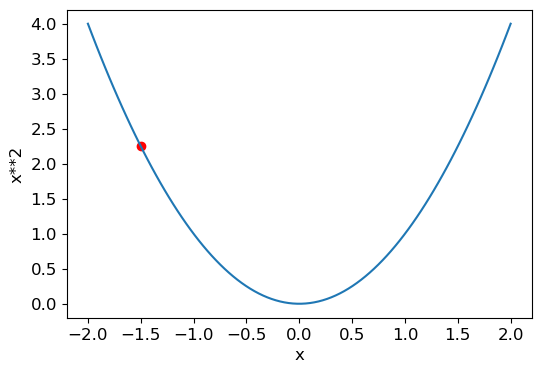

In [20]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red')

In [21]:
xt = tensor(3.).requires_grad_()

In [22]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [23]:
yt.backward()

In [24]:
xt.grad 

tensor(6.)

In [25]:
xt = tensor(3.,4.,10.).requires_grad_()

In [26]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [27]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

Small notes about tensors:
- Tensors will automatically change type when needed
- functionally identical to numpy arrays.

## Computing metrics using broadcasting

In [28]:
valid_3_t = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_t = valid_3_t.float()/255
valid_3_t.shape

torch.Size([1010, 28, 28])

In [29]:
valid_7_t = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_t = valid_7_t.float()/255
valid_7_t.shape

torch.Size([1028, 28, 28])

Now begins the magic of broadcasting.
PyTorch treats the ideal image tensor, as 1010 copies of the same tensor and allows us to apply the mse function on it. We now get a rank 1 tensor of length 1010.

In [30]:
def new_mae(a,b): return (a-b).abs().mean((-1,-2))
#mean((-1,-2)) indicates that the mean should be taken over the last two axes of the tensor

In [31]:
new_mae(valid_3_t[1], mean3)

tensor(0.1114)

In [32]:
new_mae(valid_3_t, mean3)

tensor([0.1288, 0.1114, 0.1183,  ..., 0.1406, 0.1047, 0.1095])

In [33]:
new_mae(valid_3_t, mean3).shape

torch.Size([1010])

In [34]:
def is_3(x): return new_mae(x, mean3) < new_mae(x, mean7)

In [35]:
is_3(valid_3_t)

tensor([ True,  True,  True,  ..., False,  True,  True])

In [36]:
#Checking accuracy for 3s
acc_3 = is_3(valid_3_t).float().mean()
acc_3

tensor(0.9168)

## Stochastic Gradient Descent (SGD)

Main idea behind how it works:

We want a function:

```python
def pr_eight(x,w): return (x*w).sum()
```

Where:
- x is the image, represented as a vector
- w are the weights, and correspond to how likely a pixel is to be activated in 8

Our plan:
1. Initialise the weights
2. For each image, use the weights to predict whether its a 3 or 7
3. For each prediction, calculate the loss
4. calculate the gradients for the weights
5. *step* the weights
6. return to step 2 and repeat the process
7. iterate until you want to stop the training process

## End to end SGD Example

In [37]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

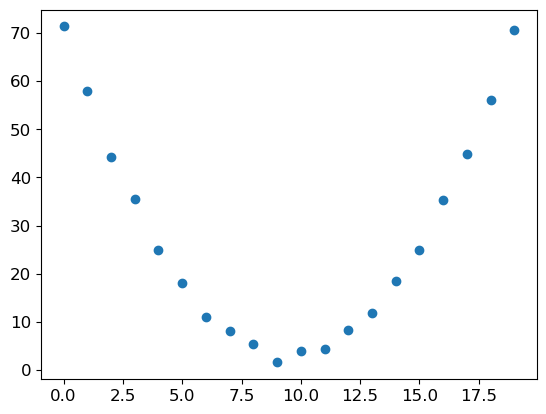

In [38]:
speed = torch.rand(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed)

In [39]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

def mse(preds, targets): return ((preds-targets)**2).mean()

In [40]:
# init weights
weights  = torch.randn(3).requires_grad_()
orig_params = weights.clone()

In [41]:
preds = f(time, weights)

In [42]:
def show_preds(preds, ax=None):
    if ax is None: ax= plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

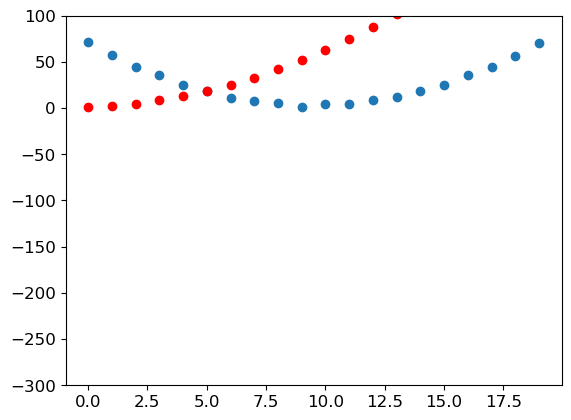

In [43]:
show_preds(preds)

### Improving our predictions

In [44]:
lr = 1e-5
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr*params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

In [45]:
for i in range(10): apply_step(weights)

6271.15576171875
1722.9986572265625
862.3447265625
699.4794311523438
668.6570434570312
662.8212890625
661.7135620117188
661.5006103515625
661.4569091796875
661.4454345703125


In [46]:
weights = orig_params.detach().requires_grad_()

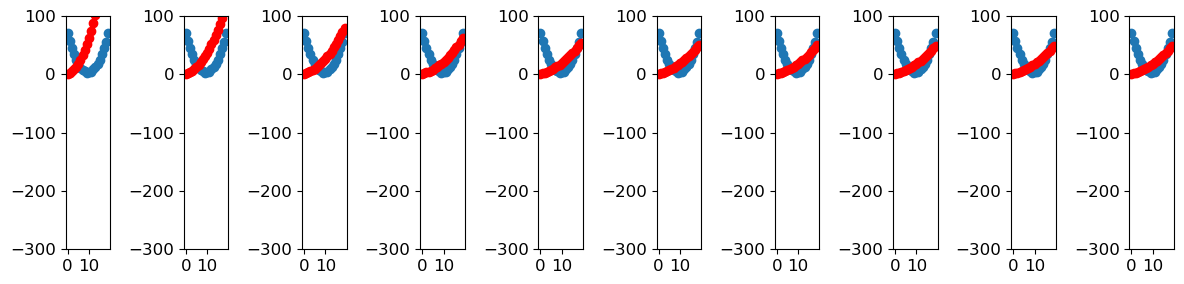

In [47]:
_,axs = plt.subplots(1,10, figsize = (12,3))
for ax in axs: show_preds(apply_step(weights, False), ax)
plt.tight_layout()

## MNIST Loss Function

First, we will concatenate all the training images into a single tensor. This can be done using ```view``` , that changes the shape of a tensor. Providing the argument ```-1``` means to make the axis as large as possible to fit all the data

In [48]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1,28*28) 
# essentially, we are flattening every image into one vector, turning a rank 3 tensor into a rank 2 tensor (a list of vectors)

In [49]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
#providing a label for each image (1 is three, 0 is seven)
train_x.shape, train_y.shape


(torch.Size([12396, 784]), torch.Size([12396, 1]))

A ```Dataset``` in PyTorch needs to return a tuple of (x,y). This can be done using the python zip function, combined with a list

In [50]:
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [51]:
valid_x = torch.cat([valid_3_t, valid_7_t]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_t) + [0]*len(valid_7_t)).unsqueeze(1)

In [52]:
valid_dset = list(zip(valid_x, valid_y))

In [53]:
x,y = valid_dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [54]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [55]:
weights = init_params((28*28,1))

In [56]:
bias = init_params(1)

Prediction for one image:

In [57]:
(train_x[0]*weights.T).sum() + bias

tensor([6.0210], grad_fn=<AddBackward0>)

In python, we can do matrix multiplication with the @ operator.

In [58]:
def linear1(xb): return xb@weights + bias

In [59]:
preds = linear1(train_x)
preds

tensor([[  6.0209],
        [ -7.9800],
        [-11.1979],
        ...,
        [-11.9900],
        [  7.9160],
        [ -1.7560]], grad_fn=<AddBackward0>)

In [60]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [False],
        [False],
        ...,
        [ True],
        [False],
        [ True]])

In [61]:
corrects.float().mean().item()

0.3568086624145508

# Loss Function

We use a loss function because, sometimes small changes in the weights will not affect the accuracy of the model. This is because the accuracy only changes when it switches from a 3 to a 7 for example, and hence accuracy is not a good metric for the machine to learn.

Ideally, our loss fucntion must be reaonsably smooth.

In [62]:
def mnist_loss(preds, tgt):
    return torch.where(tgt == 1, 1-preds, preds).mean()

trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])
mnist_loss(prds,trgts)
#torch.where(a,b,c) runs b[i] if [a], else c[1]. The above line gives how close it is to a 1 if it should be one, else how close it is to 0.

tensor(0.4333)

In [63]:
prds   = tensor([0.9, 0.2, 0.2])
mnist_loss(prds,trgts)
#Now our loss goes down if we make a change

tensor(0.3667)

To ensure we always input a value between 0 and 1, we can use the sigmoid function.

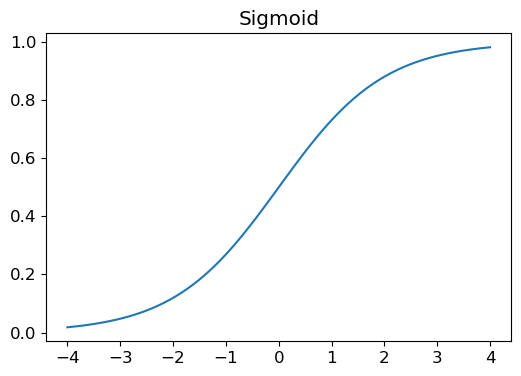

In [64]:
def sigmoid(x): return 1/(1+torch.exp(-x))
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [65]:
def mnist_loss(predictions, target):
    predictions = predictions.sigmoid()
    return torch.where(target==1, 1-predictions, predictions).mean()

## SGD Mini Batching

We use batching because:
- it is not efficient to compute the loss over the entire training dataset for each epoch
- using only one data point will not be a stable estimate of the performance of the model
- allows the division of work to the GPU which makes it more efficient

Considerations:

- using too large of a batch 

In [66]:
# Using a dataloader, which simply turns any python collection into a list of batches to iterate over
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

Recall our process:

```python

for x,y in dl:
    pred = model(x)
    loss = loss_func(x, y)
    loss.backward() #tells us to calculate the gradients 
    parameters -= parameters.grad*lr #only after we call backward can we call grad.
```

### Putting it all together

In [67]:
weights = init_params((28*28,1))
bias = init_params(1)

In [68]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [69]:
valid_dl = DataLoader(valid_dset, batch_size=256)

python operations whose names end in _ modify their objects inplace

In [70]:
batch = train_x[:4]
preds = linear1(batch)
preds

tensor([[10.2649],
        [ 0.3174],
        [-7.0234],
        [ 7.4380]], grad_fn=<AddBackward0>)

In [71]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.3553, grad_fn=<MeanBackward0>)

In [72]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [73]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0087), tensor([-0.0613]))

In [74]:
#calling it twice changes the gradients because loss.backward adds the gradients of loss. hence, we need to set current gradients to 0
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0175), tensor([-0.1227]))

In [75]:
def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [76]:
def batch_acc(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [77]:
batch_acc(linear1(batch), train_y[:4])

tensor(0.7500)

In [78]:
def validate_epoch(model):
    accs = [batch_acc(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [79]:
validate_epoch(linear1)

0.3512

Train for one epoch

In [80]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.4907

Train for 20 epochs

In [81]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.4932 0.4941 0.4951 0.4996 0.5328 0.6337 0.8618 0.9277 0.9463 0.9546 0.9585 0.9619 0.9648 0.9668 0.9682 0.9697 0.9712 0.9712 0.9712 0.9726 

## Optimisers

Handles the SGD step

In [82]:
#inbuilt into pytorch (does the same thing as init_params and linear) together
linear_model = nn.Linear(28*28,1)

In [83]:
w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [84]:
class BasicOptim:
    def __init__(self, params, lr):
        self.params, self.lr = list(params), lr
    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data*self.lr
    
    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.data = None

In [85]:
opt = BasicOptim(linear_model.parameters(), lr)

In [86]:
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [87]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end = '')

In [91]:
# train_model(linear_model, 20)

In [92]:
dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_acc)

In [93]:
learn.fit(20, lr=lr)

epoch,train_loss,valid_loss,batch_acc,time
0,0.636752,0.503143,0.495584,00:00
1,0.428643,0.249334,0.773307,00:00
2,0.161172,0.155130,0.862120,00:00
3,0.072708,0.097665,0.917076,00:00
4,0.039996,0.073267,0.935721,00:00
5,0.027143,0.059542,0.949951,00:00
6,0.021813,0.050842,0.958292,00:00
7,0.019401,0.044985,0.963199,00:00
8,0.018145,0.040830,0.965653,00:00
9,0.017365,0.037744,0.968106,00:00


## Non-linearity

If we add non-linearity, or a non-linear function between the two layers, this allows them to work independently of each other and do useful work.

In [94]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

In [95]:
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [96]:
#This can be done using pytorch in only a few short lines of code
simple_net = nn.Sequential( 
    nn.Linear(28*28, 30), 
    nn.ReLU(),
    nn.Linear(30,1)
    )#the second layer must have 30 input layers and one output layer

nn.Sequential creates a module that calls each of the listed layers or fuinctions in turn.


In [99]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_acc)
#hide_output
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_acc,time
0,0.315758,0.396935,0.511776,00:00
1,0.146455,0.229519,0.804220,00:00
2,0.081179,0.115720,0.916585,00:00
3,0.053299,0.078208,0.940628,00:00
4,0.040348,0.061204,0.955348,00:00
5,0.033741,0.051631,0.962709,00:00
6,0.029955,0.045566,0.965162,00:00
7,0.027500,0.041402,0.967615,00:00
8,0.025736,0.038362,0.969578,00:00
9,0.024372,0.036041,0.970559,00:00


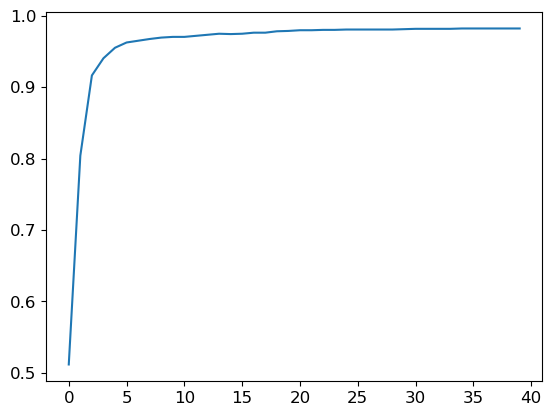

In [100]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [103]:
learn.recorder.values[-1][2]

0.98233562707901

1. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?

In [109]:
x = [1,2,3,4]
y = 'abcd'
l = list(zip(x,y))
l

[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]

## Answers to questions

1. How is a grayscale image represented on a computer? How about a color image?
- Represented as [0,256] indicating the "darkness" of a pixel?  Value of 0 represents white and 255 black.
- Colour images are three-tuples of RGB values


2. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?

- They are stored in train and validation folders, divided into image files for each number. This is because data is often divided into train and validation datasets anyways for use in ML



3. Explain how the "pixel similarity" approach to classifying digits works.

- Calculate the "mean" pixel, and determine which of the mean numbers the image is closest to

4. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.

- Loops through items in list for some condition and applies a func to them?

[2*x for x in numbers if x % 2 == 1]

5. What is a "rank-3 tensor"?

- A tensor with 3 dimensions. (list of matrices)

6. What is the difference between tensor rank and shape? How do you get the rank from the shape?

- Rank is the number of dimensions or axes, and shape is the size of dimensions. The number of entries or length of shape is the rank

7. What are RMSE and L1 norm?

- RMSE is the root mean squared error
- L1 norm is the absolute mean error


8. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?

- USE matrix multiplication?


9. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.

```python
t = tensor(range(1,10)).reshape(3,3)
t = 2*t
t

select = t[1:4,1:4]
select
```


10. What is broadcasting?

- Where PyTorch automatically fills in the missing values to ensure that matrix multiplication ? and addition make sense

11. Are metrics generally calculated using the training set, or the validation set? Why?

- Generally the validation set to prevent overfitting

12. What is SGD?

- Essentially, changing the gradient of the weights a little bit to improve the loss function

13. Why does SGD use mini-batches?
- speeds up processing

14. What are the seven steps in SGD for machine learning?

- Initialise the weights
- Make prediction using weights
- Calculate loss of prediction
- calculate gradients for weights
- step weights
- return to step 2 and repeat
- iterate until you want to stop training

15. How do we initialize the weights in a model?
- randomly
16. What is "loss"?
- diff between predicted and actual
17. Why can't we always use a high learning rate?
- stuck or slow
18. What is a "gradient"?
19. Do you need to know how to calculate gradients yourself?
- no
20. Why can't we use accuracy as a loss function?
- Not smooth

21. Draw the sigmoid function. What is special about its shape?
22. What is the difference between a loss function and a metric?
- loss func needs to be smooth, metrics can be not smooth

23. What is the function to calculate new weights using a learning rate?
- params.data -= params*lr

24. What does the `DataLoader` class do?
- Turns a python collection into a list of batches to iterate over

25. Write pseudocode showing the basic steps taken in each epoch for SGD.

```def train_epoch(model, params, lr):
        for xb,yb in dl:
            calc_grad(xb, yb, model):
            for p in params:
                p.data -= p.grad*lr
                p.grad.zero_()
    for i in range(20):
        train_epoch(model, lr, params)
```

26. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?

- It is a tuple that contains the inputs and outputs zipped

27. What does `view` do in PyTorch?

- can change the shape of a tensor without changing the contents (similar to reshape)

28. What are the "bias" parameters in a neural network? Why do we need them?

- prevents 0 weights 
29. What does the `@` operator do in Python?

- matrix multiplication
30. What does the `backward` method do?
- tells them to make a backwards pass, e.g. calculate gradients for weights
31. Why do we have to zero the gradients?
- .backward will add the current gradients to memory?

32. What information do we have to pass to `Learner`?

- data, model, optimisation, loss, metric

33. Show Python or pseudocode for the basic steps of a training loop.

- Init random variables
- preds = model (var)
- loss = loss_func(var)
- loss.backward



1. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.
1. What is an "activation function"?
1. What's the difference between `F.relu` and `nn.ReLU`?
1. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?